In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgbm
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor

# Data

In [2]:
DATAPATH = os.path.join('data', 'E03')

train = pd.read_csv(os.path.join(DATAPATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATAPATH, 'test.csv'))

In [3]:
train.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,80,0,31,0,3,31,14,4,10,1


# EDA

## Data Size
* The dataset is small. We can try out more advanced training and ensembling techniques!

In [4]:
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (1677, 35)
test shape:  (1119, 34)


In [5]:
train.describe()

,id,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
count,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,...,1677.0,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000
mean,838.000000,36.036971,892.749553,8.683959,2.937984,1.0,2.757901,67.798450,2.782349,1.998807,...,80.0,0.721527,10.709600,2.732856,2.769827,6.806798,4.144305,1.978533,4.186643,0.119261
std,484.252517,8.507112,374.496259,7.826143,1.039078,0.0,1.086835,19.435928,0.650664,1.083065,...,0.0,0.771259,7.255135,1.145271,0.647721,5.883282,3.583398,3.045716,3.576189,0.324192
min,0.000000,18.000000,107.000000,1.000000,1.000000,1.0,1.000000,30.000000,1.000000,1.000000,...,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,419.000000,30.000000,589.000000,2.000000,2.000000,1.0,2.000000,51.000000,2.000000,1.000000,...,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000
50%,838.000000,35.000000,890.000000,7.000000,3.000000,1.0,3.000000,69.000000,3.000000,2.000000,...,80.0,1.000000,9.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,0.000000
75%,1257.000000,41.000000,1223.000000,12.000000,4.000000,1.0,4.000000,84.000000,3.000000,2.000000,...,80.0,1.000000,14.000000,3.000000,3.000000,9.000000,7.000000,2.000000,7.000000,0.000000
max,1676.000000,60.000000,3921.000000,29.000000,15.000000,1.0,4.000000,100.000000,4.000000,7.000000,...,80.0,3.000000,41.000000,6.000000,4.000000,41.000000,18.000000,15.000000,17.000000,1.000000


# Train Model

In [6]:
train = train.set_index('id')

num_features = train.select_dtypes(include=np.number).columns.tolist()

cat_features = train.select_dtypes(include=object).columns.tolist()

target = 'Attrition'

y = train[target]

all_features = train.drop([target], axis=1).columns.tolist()

In [7]:
from category_encoders import WOEEncoder

for col in cat_features:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    
woe = WOEEncoder(drop_invariant=True, randomized = True)
woe.fit(train[all_features], train['Attrition'], cols = cat_features)
df_train = woe.transform(train[all_features])
df_test = woe.transform(test[all_features])
all_features = df_train.columns.tolist()

In [8]:
import warnings
warnings.filterwarnings('ignore')

clfs = []
scores = []
kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

params = {'max_depth': 3,
          'learning_rate': 0.1,
          'min_child_weight': 5,
          'subsample': 0.7,
          'colsample_bytree': 0.3
         }

for i, (train_index, val_index) in enumerate(kf.split(df_train, y=y)):
    X_train, X_val = df_train[all_features].loc[train_index], df_train[all_features].loc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    clf = XGBClassifier(**params,
                        n_estimators=20000,
                        seed=42)
    
    clf.fit(X_train.values, y_train,
            early_stopping_rounds=100, 
            eval_set=[(X_val.values, y_val)], 
            eval_metric=['auc'],
            verbose=1000)
    
    preds = clf.predict_proba(X_val.values)
    auc = roc_auc_score(y_val, preds[:, 1])
    
    clfs.append(clf)
    scores.append(auc)
    print(f'Score on fold {i}: {auc}')
    print('-'*75)
    
print(f'Mean score across all folds: {np.mean(scores)}')

[0]	validation_0-auc:0.58125
[325]	validation_0-auc:0.80169
Score on fold 0: 0.8287162162162163
---------------------------------------------------------------------------
[0]	validation_0-auc:0.59882
[153]	validation_0-auc:0.80743
Score on fold 1: 0.8199324324324324
---------------------------------------------------------------------------
[0]	validation_0-auc:0.67872
[197]	validation_0-auc:0.84764
Score on fold 2: 0.8675675675675675
---------------------------------------------------------------------------
[0]	validation_0-auc:0.67010
[173]	validation_0-auc:0.82635
Score on fold 3: 0.8712837837837838
---------------------------------------------------------------------------
[0]	validation_0-auc:0.64578
[145]	validation_0-auc:0.78851
Score on fold 4: 0.8077702702702703
---------------------------------------------------------------------------
[0]	validation_0-auc:0.58581
[110]	validation_0-auc:0.78919
Score on fold 5: 0.7945945945945947
--------------------------------------------

## LGBMClassifier

In [9]:
scores = []

params = {'learning_rate': 0.09,
          'num_leaves': 195,
          'max_depth': 2,
          'min_child_samples': 46,
          'reg_alpha': 0.05,
          'reg_lambda': 0.1,
          'subsample': 0.45,
          'colsample_bytree': 0.3}

for i, (train_index, val_index) in enumerate(kf.split(df_train, y=y)):
    X_train, X_val = df_train[all_features].loc[train_index], df_train[all_features].loc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    clf = lgbm.LGBMClassifier(**params,
                              n_estimators=20000,
                              metric='auc',
                              random_state=42)
    
    clf.fit(X_train.values, y_train, 
            eval_set=[(X_val.values, y_val)],
            eval_metric=['auc'],
            callbacks=[lgbm.early_stopping(100, verbose=True)])
            
    preds = clf.predict_proba(X_val.values)
    auc = roc_auc_score(y_val, preds[:, 1])
    
    clfs.append(clf)
    scores.append(auc)
    print(f'Score on fold {i}: {auc}')
    print('-'*75)
    
print(f'Mean score across all folds (with original data): {np.mean(scores)}')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[208]	valid_0's auc: 0.801351
Score on fold 0: 0.8013513513513514
---------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[210]	valid_0's auc: 0.831757
Score on fold 1: 0.8317567567567569
---------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	valid_0's auc: 0.860811
Score on fold 2: 0.8608108108108109
---------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	valid_0's auc: 0.902027
Score on fold 3: 0.902027027027027
---------------------------------------------------------------------------
Training until validation scores don't improve

## CatBoostClassifier

In [10]:
scores = []

params = {'loss_function': 'CrossEntropy',
          'learning_rate': 0.76,
          'l2_leaf_reg': 0.014,
          'colsample_bylevel': 0.06,
          'depth': 1,
          'boosting_type': 'Plain',
          'bootstrap_type': 'Bernoulli',
          'min_data_in_leaf': 18,
          'subsample': 0.8}

for i, (train_index, val_index) in enumerate(kf.split(df_train, y=y)):
    X_train, X_val = df_train[all_features].loc[train_index], df_train[all_features].loc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    clf = CatBoostClassifier(**params,
                            iterations=20000,
                            eval_metric='AUC',
                            random_state=42)
    
    clf.fit(X_train.values, y_train, 
            eval_set=(X_val.values, y_val),
            early_stopping_rounds=100, verbose=1000)
    
    preds = clf.predict_proba(X_val.values)
    auc = roc_auc_score(y_val, preds[:, 1])
    
    clfs.append(clf)
    scores.append(auc)
    print(f'Score on fold {i}: {auc}')
    print('-'*85)
    
print(f'Mean score across all folds: {np.mean(scores)}')

0:	test: 0.5000000	best: 0.5000000 (0)	total: 150ms	remaining: 49m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7989864865
bestIteration = 94

Shrink model to first 95 iterations.
Score on fold 0: 0.7989864864864865
-------------------------------------------------------------------------------------
0:	test: 0.5000000	best: 0.5000000 (0)	total: 764us	remaining: 15.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8375
bestIteration = 192

Shrink model to first 193 iterations.
Score on fold 1: 0.8375
-------------------------------------------------------------------------------------
0:	test: 0.5000000	best: 0.5000000 (0)	total: 873us	remaining: 17.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8766891892
bestIteration = 87

Shrink model to first 88 iterations.
Score on fold 2: 0.8766891891891893
-------------------------------------------------------------------------------------
0:	test: 0.5000000	best: 0.500

## Feature importances

----------------------------XGBoost----------------------------


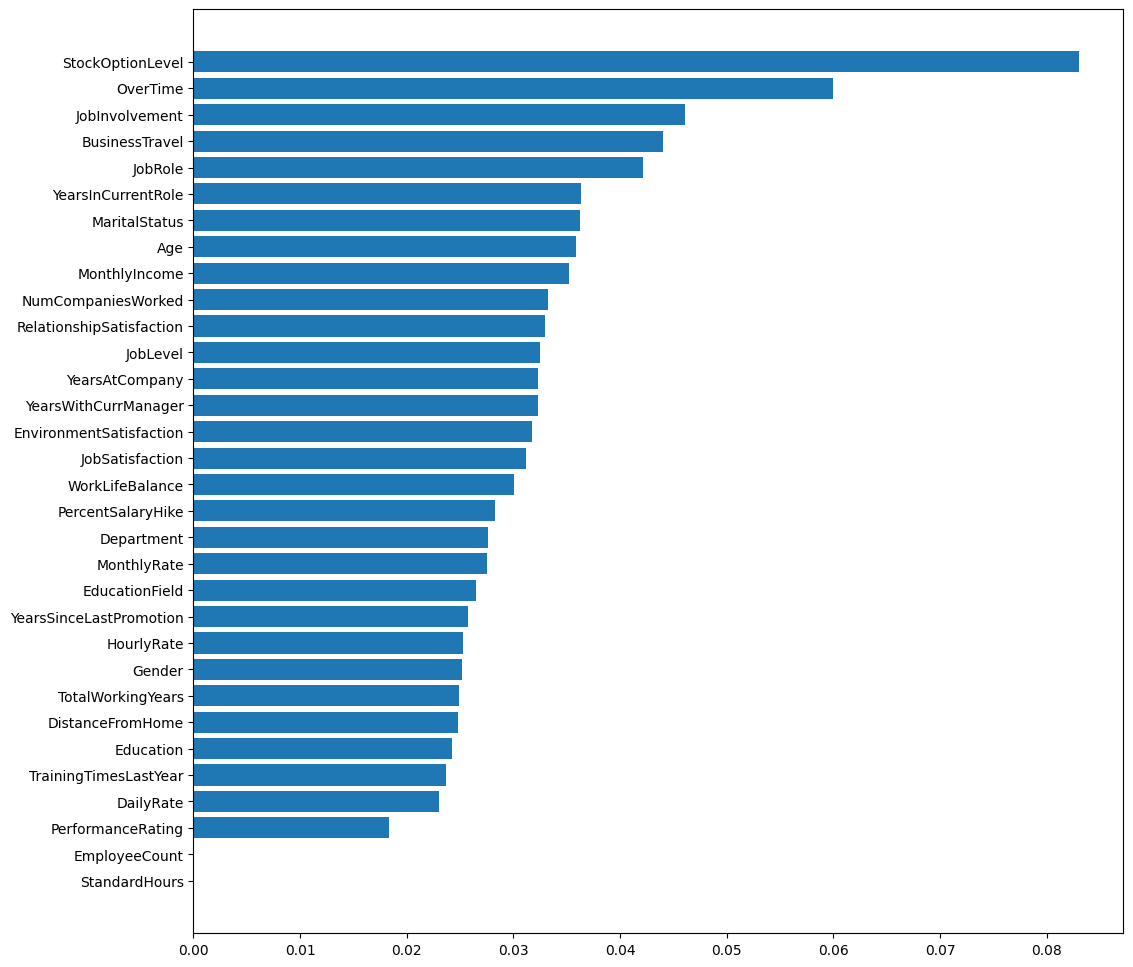

In [11]:
plt.figure(figsize=(12,12))
imp = np.zeros(32)
for clf in clfs[:10]:
    imp+= clf.feature_importances_
    
print('----------------------------XGBoost----------------------------')
plt.barh([all_features[i] for i in np.argsort(imp/10)], sorted(imp/10))
plt.show()

----------------------------LGBM----------------------------


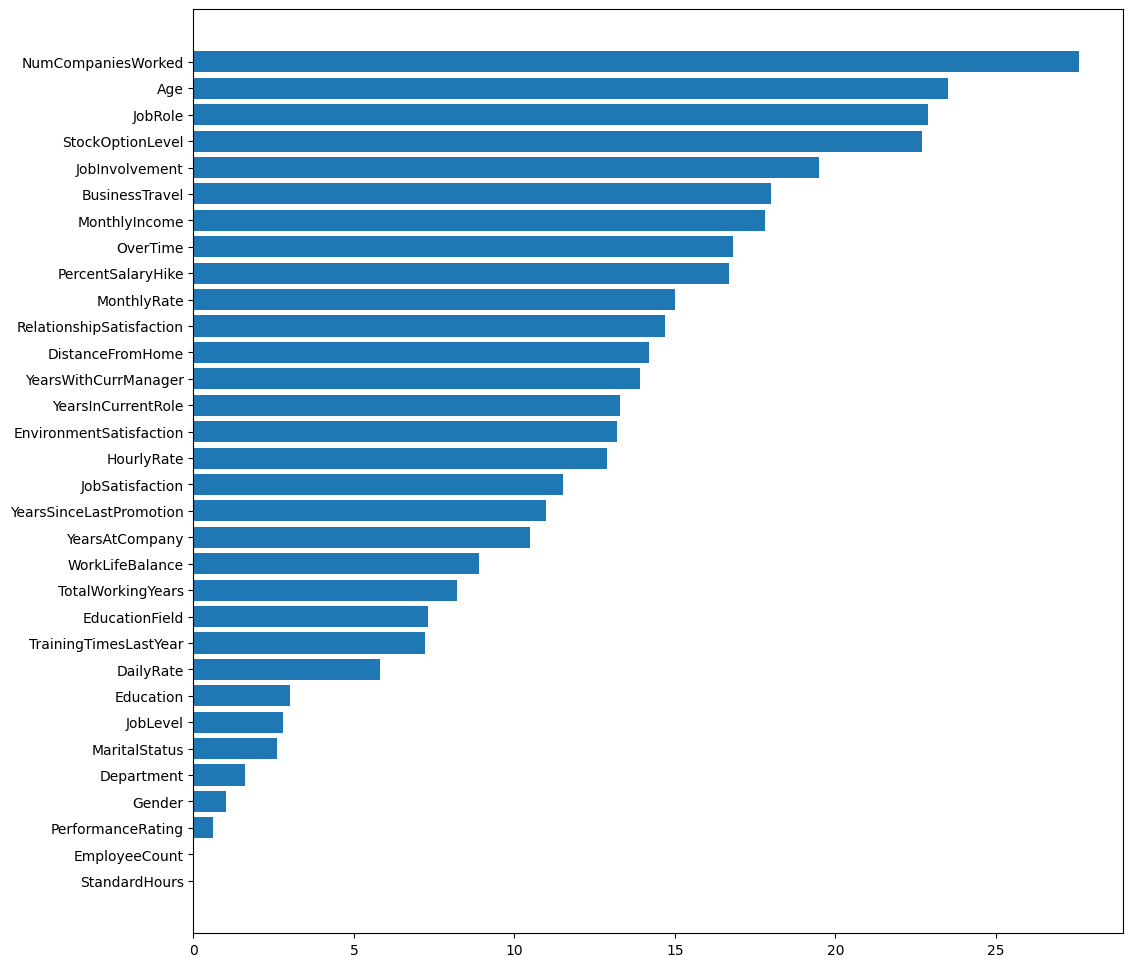

In [12]:
plt.figure(figsize=(12,12))
imp = np.zeros(32)
for clf in clfs[10:20]:
    imp+= clf.feature_importances_
    
print('----------------------------LGBM----------------------------')
plt.barh([all_features[i] for i in np.argsort(imp/10)], sorted(imp/10))
plt.show()

----------------------------CatBoost----------------------------


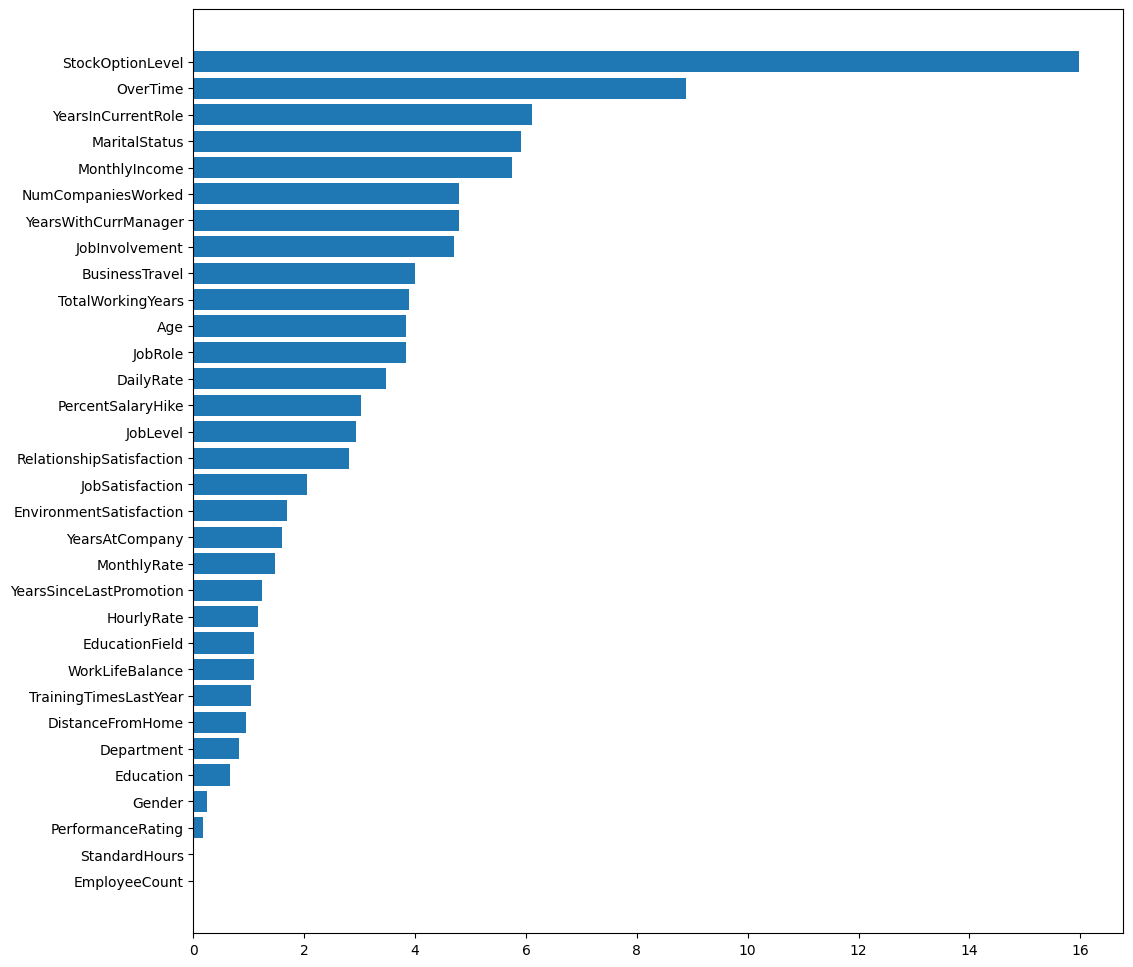

In [13]:
plt.figure(figsize=(12,12))
imp = np.zeros(32)
for clf in clfs[20:]:
    imp+= clf.feature_importances_
    
print('----------------------------CatBoost----------------------------')
plt.barh([all_features[i] for i in np.argsort(imp/10)], sorted(imp/10))
plt.show()

# Making submission

In [15]:
test_preds1 = []
test_preds2 = []
test_preds3 = []

for clf in clfs[:10]:
    preds = clf.predict_proba(df_test[all_features].values)
    test_preds1.append(preds[:, 1])
    
for clf in clfs[10:20]:
    preds = clf.predict_proba(df_test[all_features].values)
    test_preds2.append(preds[:, 1])
    
for clf in clfs[20:]:
    preds = clf.predict_proba(df_test[all_features].values)
    test_preds3.append(preds[:, 1])

In [16]:
test_preds1 = np.stack(test_preds1).mean(0)
test_preds2 = np.stack(test_preds2).mean(0)
test_preds3 = np.stack(test_preds3).mean(0)

In [17]:
test_preds = test_preds1*0.3 + test_preds2*0.3 + test_preds3*0.4

In [18]:
submission = pd.DataFrame(data={'id': test.id, 'Attrition': test_preds})
submission.head()

,id,Attrition
0,1677,0.260622
1,1678,0.086249
2,1679,0.054098
3,1680,0.072115
4,1681,0.647806


In [19]:
submission.to_csv('submission.csv', index=False)